# Demonstrate Unscented Kálmán Filter (UKF)
Demonstrate the UKF filter on estimating the resistance of a single-resistor circuit

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from asoh.online.ukf import UnscentedKalmanFilter
from asoh.models.ecm import ECMInput, ECMMeasurements, ECMState, SingleResistorModel
import pandas as pd
import numpy as np

Configuration

In [2]:
actual_rint: float = 0.1  # Actual resistance 
guess_rint: float = 0.05  # Guess for resistance
charge_time: float = 3600.  # Interval over which to charge and discharge the battery
observations_per_charge: int = 360  # How many times to measure voltage during charge
current: float = 1.  # Applied current during charge or discharge
cycle_count: int = 4  # Number of cycles to simulate

## Create the Model
The ASOH package defines a dynamic system with two parts:
1. A "Model" that describes how to update the state of a dynamic system
2. A "State" defining the parameters for a specific system

Our model, which implements an ECM with a single resistor, does not have any controlable variables.

In [3]:
model = SingleResistorModel()

Define the state of the system (e.g., it's charge) and the parameters which define its dynamics using the "State"

In [4]:
actual_state = ECMState(charge=0., r_serial=actual_rint, ocv_params=(1., 0.5))
actual_state

ECMState(health_params=(), covariance=array([[1.]]), state_params=('charge',), charge=0.0, r_serial=0.1, ocv_params=(1.0, 0.5))

In [5]:
actual_state.model_dump()

{'health_params': (),
 'covariance': array([[1.]]),
 'state_params': ('charge',),
 'charge': 0.0,
 'r_serial': 0.1,
 'ocv_params': (1.0, 0.5)}

The dynamics of a system are controlled by outside forces, which are described by a "Control" class.

Our simple circuit uses only the applied current as control. 

Employ the model to update the state under the influence of this control signal

In [6]:
model.update(state=actual_state, control=ECMInput(current=1.), total_time=3600.)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.111e+00  1.111e+01  1.111e+02  1.111e+03  3.600e+03]
        y: [[ 0.000e+00  2.778e-08  3.056e-07  3.083e-06  3.086e-05
              3.086e-04  3.086e-03  3.086e-02  3.086e-01  1.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 56
     njev: 0
      nlu: 0

In [7]:
print(f'Charge after 1 hour of 1 A current: {actual_state.charge:.2f} A-hr')

Charge after 1 hour of 1 A current: 1.00 A-hr


The other function of the model is to predict the observables of a system given the state and control signal.

In [8]:
y = model.output(actual_state, control=ECMInput(current=-1.))
y

ECMMeasurements(terminal_voltage=1.4)

The terminal voltage is the only observable signal from our system

In [9]:
actual_state.charge = 0.  # Reset to a fully-discharged state

## Estimate the State
State estimation is the process of determing the parameters of a dynamic system given observations of its behavior.

The ASOH package does so using an "observer" class which gradually alters the estimate of a state of a system given many signals over time.

### Defining which Parameters to Estimate
Start with building a guess for the initial state that also lists which parameters of the system we're unsure about marked as the "health params"

In [10]:
state = ECMState(
    charge=0., 
    r_serial=guess_rint, 
    ocv_params=(1., 0.5),
    health_params=('r_serial',),
)
state

ECMState(health_params=('r_serial',), covariance=array([[1., 0.],
       [0., 1.]]), state_params=('charge',), charge=0.0, r_serial=0.05, ocv_params=(1.0, 0.5))

Note that the state includes a covariance, which represents the probability distribution for the parameters we're fitting.

In this case, those parameters are the state of charge of the system and the resistance of the resistor

In [11]:
state.covariance

array([[1., 0.],
       [0., 1.]])

In [12]:
state.full_params

('charge', 'r_serial')

## Using the OnlineEstimator
OnlineEstimator classes are tied to a specific model and specific instance being evaluated. Create only by supplying the Model and State to the initial value

In [13]:
ukf = UnscentedKalmanFilter(model, state, covariance_process_noise=np.eye(2,) * 1e-3, covariance_sensor_noise=np.array([[1e-2]]))

All observers define a "step" function that updates the estimate of a state given
the control signal applied at a new step, 
the observed outputs,
and the length of time between this step and the last.

In [14]:
help(ukf.step)

Help on method step in module asoh.online.ukf:

step(u: asoh.models.base.InputState, y: asoh.models.base.Measurements, t_step: float) method of asoh.online.ukf.UnscentedKalmanFilter instance
    Update the state estimation given a new set of control states
    
    Args:
        u: Control states at the new time step
        y: Observed outputs at the new time step
        t_step: Time elapsed between last and current timestep
    Returns:
        Diagnostic information



We'll run very many cycles and record the changes in step after each

In [15]:
time = 0
timestep = charge_time / observations_per_charge
state_names = ('time',) + state.full_state_names + tuple(f'var_{s}' for s in state.full_state_names)
full_states = []
while time < cycle_count * charge_time * 2:
    
    # Start by charging
    for step_current in [current, -current]:
        control = ECMInput(current=step_current)
        for i in range(observations_per_charge):
            time += timestep
            model.update(actual_state, control, timestep)
            ukf.step(control, model.output(actual_state, control), timestep)
            full_states.append([time] + ukf.state.full_state.tolist() + np.diag(ukf.state.covariance).tolist())
        

In [16]:
full_states = pd.DataFrame(full_states, columns=state_names)

Plot the estimated charge

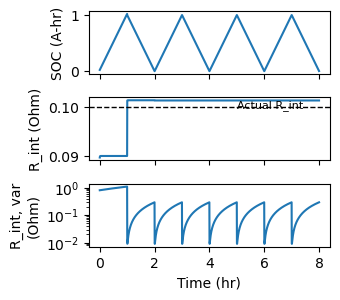

In [17]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3.5, 3.1))

axs[0].plot(full_states['time'] / 3600., full_states['charge'])
axs[0].set_xlim(axs[0].get_xlim())
axs[0].set_ylabel('SOC (A-hr)')

axs[1].plot(full_states['time'] / 3600., full_states['r_serial'])
axs[1].plot(axs[1].get_xlim(), [actual_rint] * 2, 'k--', lw=1)
axs[1].text(5, actual_rint, 'Actual R_int', fontsize=8)
axs[1].set_ylabel('R_int (Ohm)')

axs[2].semilogy(full_states['time'] / 3600., full_states['var_charge'])
axs[2].set_ylabel('R_int, var\n(Ohm)')

axs[-1].set_xlabel('Time (hr)')

fig.tight_layout()